In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


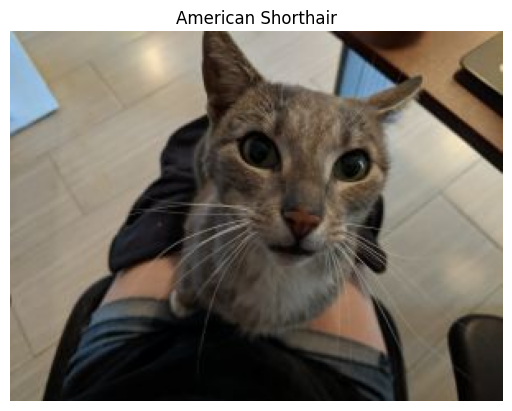

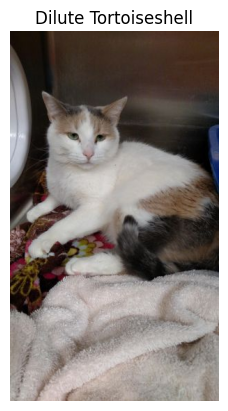

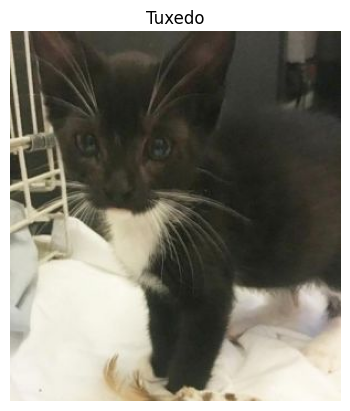

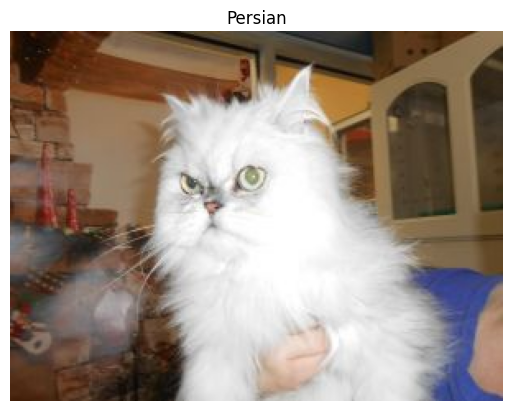

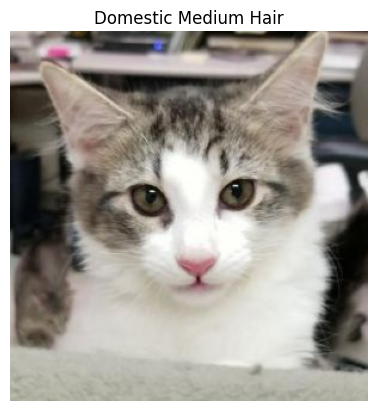

In [2]:
data_dir = '/kaggle/input/catbreed/Capstone'  # Directory path where the folders are located

# Get the list of folders in the directory
folders = os.listdir(data_dir)

# Iterate over each folder
for folder in folders:
    folder_path = os.path.join(data_dir, folder)  # Path of the current folder
    images = os.listdir(folder_path)  # Get the list of images in the folder
    
    if len(images) > 0:
        # Get the path of the first image in the folder
        image_path = os.path.join(folder_path, images[4])
        
        # Display the image
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(folder)  # Display the folder name as the title
        plt.axis('off')  # Hide the axis
        plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to the dataset
data_dir = '/kaggle/input/catbreed/Capstone'

# Set the parameters for training the model
batch_size = 32
image_size = (256, 256)
input_shape = (256, 256, 3)
num_classes = 5
epochs = 10


In [4]:
# Preprocess and augment the data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
# Load and split the data into training and validation sets
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 12000 images belonging to 5 classes.


In [6]:
valid_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 3000 images belonging to 5 classes.


In [7]:
# Define the callbacks
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [9]:
# Build the CNN model
num_classes = 5
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [10]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

In [11]:
# Compile the model
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Print the details of the data generators
print("Training Generator:")
print("Number of samples:", train_generator.samples)
print("Number of classes:", train_generator.num_classes)
print("Class labels:", train_generator.class_indices)
print()

print("Validation Generator:")
print("Number of samples:", valid_generator.samples)
print("Number of classes:", valid_generator.num_classes)
print("Class labels:", valid_generator.class_indices)

Training Generator:
Number of samples: 12000
Number of classes: 5
Class labels: {'American Shorthair': 0, 'Dilute Tortoiseshell': 1, 'Domestic Medium Hair': 2, 'Persian': 3, 'Tuxedo': 4}

Validation Generator:
Number of samples: 3000
Number of classes: 5
Class labels: {'American Shorthair': 0, 'Dilute Tortoiseshell': 1, 'Domestic Medium Hair': 2, 'Persian': 3, 'Tuxedo': 4}


In [13]:
# Train the model with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[checkpoint]
)


Epoch 1/100
375/375 [==============================] - 341s 886ms/step - loss: 1.4686 - accuracy: 0.3207 - val_loss: 1.4226 - val_accuracy: 0.3515
Epoch 2/100
375/375 [==============================] - 231s 615ms/step - loss: 1.4182 - accuracy: 0.3615 - val_loss: 1.3982 - val_accuracy: 0.3992
Epoch 3/100
375/375 [==============================] - 271s 722ms/step - loss: 1.3811 - accuracy: 0.3959 - val_loss: 1.3630 - val_accuracy: 0.4150
Epoch 4/100
375/375 [==============================] - 273s 729ms/step - loss: 1.3472 - accuracy: 0.4267 - val_loss: 1.3050 - val_accuracy: 0.4439
Epoch 5/100
375/375 [==============================] - 266s 711ms/step - loss: 1.3234 - accuracy: 0.4387 - val_loss: 1.2817 - val_accuracy: 0.4603
Epoch 6/100
375/375 [==============================] - 233s 622ms/step - loss: 1.2987 - accuracy: 0.4497 - val_loss: 1.2868 - val_accuracy: 0.4708
Epoch 7/100
375/375 [==============================] - 230s 614ms/step - loss: 1.2886 - accuracy: 0.4629 - val_loss: 1

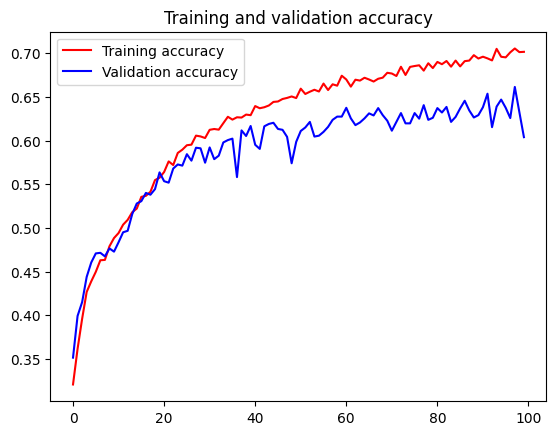

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()



plt.show()

In [15]:
import json
from keras.models import model_from_json

# Assuming your trained model is named 'model' and it's stored in a variable

# Save the model architecture as JSON
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights in HDF5 format
model.save_weights('model_weights.h5')
